In [21]:
import pandas as pd
import numpy as np

In [22]:
video_games_sales=pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016.csv")

In [23]:
v2 = video_games_sales.drop(columns=['User_Score', 'NA_Sales', 'JP_Sales', 'Other_Sales', 'Year_of_Release', 'EU_Sales'])

# Checking the shape of the reduced columns DataFrame
reduced_shape = v2.shape
reduced_shape

(16719, 10)

In [24]:
##################TRAIN TEST SPLIT de 13375 Global sales värden i y_train är vår target########################
from sklearn.model_selection import train_test_split

#  target  'Global_Sales' 
X = v2.drop(columns=['Global_Sales'])  
y = v2['Global_Sales']  

#  split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"train{X_train.shape}, {y_train.shape}")
print(f"test {X_test.shape}, {y_test.shape}")

train(13375, 9), (13375,)
test (3344, 9), (3344,)


In [25]:
############  Reference model with just all empty rows cleaned  (no encoding no 'curse of dimensionality yet'#####

In [26]:
combined = pd.concat([X_train, y_train], axis=1)

combined_cleaned = combined.dropna()

X_train_c = combined_cleaned.iloc[:, :-1]  # All columns except the last
y_train_c = combined_cleaned.iloc[:, -1] 

In [9]:
borttagna_rader = combined_cleaned
borttagna_rader.to_csv('borttagna_rader.csv', index=False)


In [10]:
X_test_c.info()

NameError: name 'X_test_c' is not defined

In [11]:
combined = pd.concat([X_test, y_test], axis=1)

combined_cleaned = combined.dropna()

X_test_c = combined_cleaned.iloc[:, :-1]  # All columns except the last
y_test_c = combined_cleaned.iloc[:, -1]  

In [12]:
### Catboost model fitted as reference model without any  feature engineering being done yet#########
from catboost import CatBoostRegressor
categorical_features = ['Name', 'Platform', 'Genre', 'Publisher', 'Developer', 'Rating']
model_c = CatBoostRegressor(cat_features=categorical_features, verbose=0)  # 0 to suppresses output
model_c.fit(X_train_c, y_train_c)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
pred_c = model_c.predict(X_test_c)
mae = mean_absolute_error(y_test_c, pred_c)
mse = mean_squared_error(y_test_c, pred_c)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test_c, pred_c)

# Displays
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r_squared:.2f}")

Evaluation Metrics:
Mean Absolute Error (MAE): 0.51
Mean Squared Error (MSE): 4.60
Root Mean Squared Error (RMSE): 2.14
R-squared (R²): 0.47


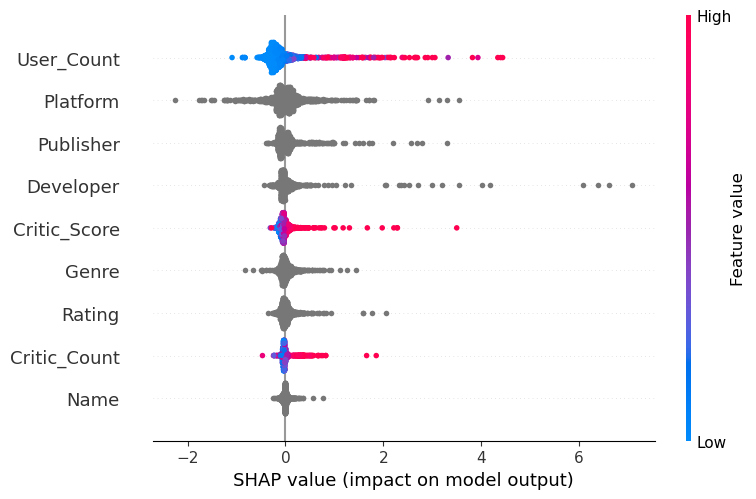

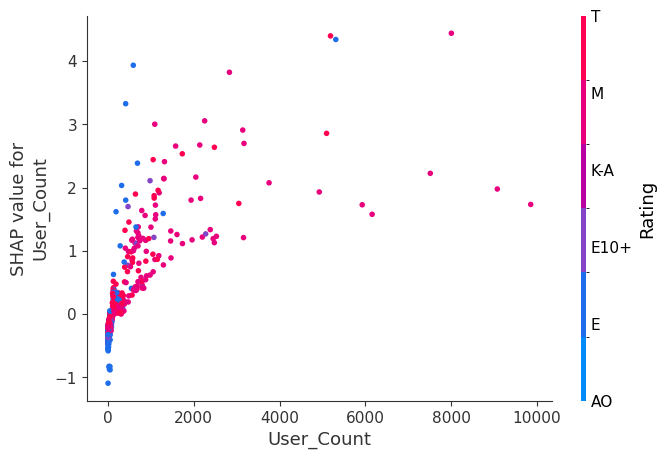

In [14]:
import shap
from catboost import Pool

# Pool object categoriska features identifieras
cat_features = ['Name', 'Platform', 'Genre', 'Publisher', 'Developer', 'Rating']
pool_data = Pool(X_test_c, cat_features=cat_features)

explainer = shap.Explainer(model_c)
shap_values = explainer.shap_values(X_test_c)

# Summary 
shap.summary_plot(shap_values, X_test_c)

# Dependence Plot for a specific feature
shap.dependence_plot('User_Count', shap_values, X_test_c)

# Force Plot for a specific instance
#instance_index = 0  # Choose the instance index you want to analyze
#shap.force_plot(explainer.expected_value, shap_values[instance_index], X_test_c.iloc[instance_index])

In [11]:
print(type(explainer))

<class 'shap.explainers._tree.TreeExplainer'>


In [15]:
################## Prediction  and some inference (shap) above
####################   reference model done### Can it be improved?? K-fold cross validation maybe ###########################

In [16]:
###################  FYLLNING AV TOMMA CELLER för att göra fit mot vår target y_train #######################
# median och mode ifyllnad X_train 
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

X_train2 = X_train.copy()
X_train2[numeric_cols] = X_train2[numeric_cols].fillna(X_train2[numeric_cols].median())


categorical_cols = X_train.select_dtypes(include=['object']).columns
X_train2[categorical_cols] = X_train2[categorical_cols].fillna(X_train2[categorical_cols].mode().iloc[0])


In [17]:
# median och mode ifyllnad X_test  (annan median o mode annars risk för data leakage)
numeric_cols = X_test.select_dtypes(include=['float64', 'int64']).columns

X_test2 = X_test.copy()
X_test2[numeric_cols] = X_test2[numeric_cols].fillna(X_test2[numeric_cols].median())


categorical_cols = X_test.select_dtypes(include=['object']).columns
X_test2[categorical_cols] = X_test2[categorical_cols].fillna(X_test2[categorical_cols].mode().iloc[0])
########################################################

In [11]:
#############   ENCODINGS for dimensionality reduction och för att skapa numeriska värden #########################

In [18]:
X_train3 = X_train2.copy()

# Create one-hot encoded columns for 'Ubisoft', 'Nintendo', and 'The rest'
X_train3['Dev_Ubisoft'] = X_train3['Developer'].apply(lambda x: 1 if x == 'Ubisoft' else 0)
X_train3['Dev_Nintendo'] = X_train3['Developer'].apply(lambda x: 1 if x == 'Nintendo' else 0)

# Create 'The rest' column (1 where Developer is not Ubisoft or Nintendo)
X_train3['Dev_rest'] = X_train3.apply(lambda row: 1 if (row['Developer'] != 'Ubisoft' and row['Developer'] != 'Nintendo') else 0, axis=1)


# Drop the original 'Developer' column
X_train3 = X_train3.drop(columns=['Developer'])

In [13]:
X_test3 = X_test2.copy()

# Create one-hot encoded columns for 'Ubisoft', 'Nintendo', and 'The rest'
X_test3['Dev_Ubisoft'] = X_test3['Developer'].apply(lambda x: 1 if x == 'Ubisoft' else 0)
X_test3['Dev_Nintendo'] = X_test3['Developer'].apply(lambda x: 1 if x == 'Nintendo' else 0)

# Create 'The rest' column (1 where Developer is not Ubisoft or Nintendo)
X_test3['Dev_rest'] = X_test3.apply(lambda row: 1 if (row['Developer'] != 'Ubisoft' and row['Developer'] != 'Nintendo') else 0, axis=1)


# Drop the original 'Developer' column
X_test3 = X_test3.drop(columns=['Developer'])

In [19]:
# one-hot encoding 'E' (Everyone) and Rest
X_train3['Rating_E'] = X_train3['Rating'].apply(lambda x: 1 if x == 'E' else 0)

#Rest column (1 where Rating is not 'E')
X_train3['Rating_Rest'] = X_train3['Rating'].apply(lambda x: 1 if x != 'E' else 0)

# Drop the old Rating column
X_train3 = X_train3.drop(columns=['Rating'])


In [20]:
# one-hot encoding 'E' (Everyone) and Rest
X_test3['Rating_E'] = X_test3['Rating'].apply(lambda x: 1 if x == 'E' else 0)

#Rest column (1 where Rating is not 'E')
X_test3['Rating_Rest'] = X_test3['Rating'].apply(lambda x: 1 if x != 'E' else 0)

# Drop the old Rating column
X_test3 = X_test3.drop(columns=['Rating'])

NameError: name 'X_test3' is not defined

In [16]:
#############   ENCODINGS STOP #########################

In [20]:
X_train_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13375 entries, 9162 to 15795
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Critic_Score  13375 non-null  float64
 1   Critic_Count  13375 non-null  float64
 2   User_Count    13375 non-null  float64
 3   Dev_Ubisoft   13375 non-null  int64  
 4   Dev_Nintendo  13375 non-null  int64  
 5   Dev_rest      13375 non-null  int64  
 6   Rating_E      13375 non-null  int64  
 7   Rating_Rest   13375 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 940.4 KB


In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
X_train_selected = X_train3.iloc[:, -8:]  # Select last 8 columns for example de är numerical nu
model = LinearRegression()
model.fit(X_train_selected, y_train)

LinearRegression()

In [21]:
coef = model.coef_
inte = model.intercept_

In [15]:
print(coef)

[ 1.27617135e-02  1.59914836e-02  6.90915202e-04 -1.50456164e+00
  2.92808081e+00 -1.42351917e+00  6.64767260e-02 -6.64767260e-02]


In [22]:
X_test_selected = X_test3.iloc[:, -8:]  # Select the same columns as training

#  Make predictions using the fitted model
predictions = model.predict(X_test_selected)

# Print predictions
print(predictions)

[0.96346622 0.45106967 0.52313025 ... 0.45106967 0.21737668 0.45106967]


In [23]:
y_test.info() 

<class 'pandas.core.series.Series'>
Int64Index: 3344 entries, 6991 to 12077
Series name: Global_Sales
Non-Null Count  Dtype  
--------------  -----  
3344 non-null   float64
dtypes: float64(1)
memory usage: 52.2 KB


In [24]:
sum(predictions) / len(predictions)

0.5401667025457714

In [25]:
sum(y_test) / len (y_test)  #ser 'bra' ut med nästan samma average som y_test på hela predictionsetet iaf

0.5654934210526248

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, predictions)

# visuals

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r_squared:.2f}")

Mean Absolute Error (MAE): 0.56
Mean Squared Error (MSE): 3.46
Root Mean Squared Error (RMSE): 1.86
R-squared (R²): 0.16


In [ ]:
##  Här finns stora möjligheter till förbättring-- Scaler--ny encoding etc...annan modell än Linear regression också